#Welcome to our Project 4 regressor notebook!

Here we will create multiple regression tech. to predict daily high, low, wind speed and precip over Champaign IL. 

First up, clone the repository. 

In [47]:
# get our project github directory 
!git clone https://github.com/mitraarka27/ATMS-597-SP-2020-Project4-GroupG.git

fatal: destination path 'ATMS-597-SP-2020-Project4-GroupG' already exists and is not an empty directory.


In [0]:
#open up the data archives (puts them in the current dir under ./bufkit)
!tar xzf ./ATMS-597-SP-2020-Project4-GroupG/ATMS-597-SP-2020-Project-4/daily.tar.gz
!tar xzf ./ATMS-597-SP-2020-Project4-GroupG/ATMS-597-SP-2020-Project-4/prof.tar.gz
!tar xzf ./ATMS-597-SP-2020-Project4-GroupG/ATMS-597-SP-2020-Project-4/sfc.tar.gz

In [50]:
import glob
import pandas as pd
import numpy as np


prof_df = pd.DataFrame(columns=['date','hght500', 'hght250', 'temp850', 'temp500', 'temp250',
                               'dwpc850', 'dwpc750', 'wspd925', 'wspd850', 'wspd500','wspd250'])
filenames = glob.glob('./bufkit/*_prof.csv'); print(filenames[0])
for nfile in range(0,len(filenames)):
    A = pd.read_csv(filenames[nfile])
    plevels =[925.0,850.0,700.0,500.0,250.0,100.0]
    for i in range (0,8):
        date = pd.to_datetime(A['Unnamed: 0'].values).date[0]
        hght = np.fromstring(A['HGHT'][i][1:-1], sep=', ')
        hght_500 = hght[3]
        hght_250 = hght[4]
        temp = np.fromstring(A['TMPC'][i][1:-1], sep=', ')
        temp_850 = temp[1]
        temp_500 = temp[3]
        temp_250 = temp[4]
        dwpc = np.fromstring(A['DWPC'][i][1:-1], sep=', ')
        dwpc_850 = dwpc[1]
        dwpc_750 = dwpc[2]
        uwnd = np.fromstring(A['UWND'][i][1:-1], sep=', ')
        vwnd = np.fromstring(A['VWND'][i][1:-1], sep=', ')
        u = uwnd[0]; v = vwnd[0]; wspd_925 = np.sqrt(u**2 + v**2)
        u = uwnd[1]; v = vwnd[1]; wspd_850 = np.sqrt(u**2 + v**2)
        u = uwnd[3]; v = vwnd[3]; wspd_500 = np.sqrt(u**2 + v**2)
        u = uwnd[4]; v = vwnd[4]; wspd_250 = np.sqrt(u**2 + v**2)
        prof_df.loc[nfile*8+i] = [date, hght_500, hght_250, temp_850,temp_500, temp_250, dwpc_850, dwpc_750,
                         wspd_925, wspd_850, wspd_500, wspd_250]
    
prof_df.to_csv("./KCMI_prof.csv", encoding='utf-8')
prof_df

./bufkit/2016062812.gfs_kcmi.buf_prof.csv


,date,hght500,hght250,temp850,temp500,temp250,dwpc850,dwpc750,wspd925,wspd850,wspd500,wspd250
0,2016-06-29,5794.218409,10723.445789,11.063810,-11.516818,-45.086316,1.306190,-28.149130,16.551860,9.153810,25.799545,63.252632
1,2016-06-29,5786.170399,10701.714211,11.771905,-11.682222,-46.782556,-4.889667,-28.818060,18.560310,9.400762,27.914615,50.261504
2,2016-06-29,5780.035114,10702.125811,10.629100,-11.802614,-45.824151,-8.716777,-25.576622,10.747442,8.109384,28.316733,78.199245
3,2016-06-29,5791.958385,10732.626316,10.663333,-12.018074,-46.375789,-9.762952,-27.598395,10.546977,9.987190,26.807110,90.219737
4,2016-06-29,5802.050028,10743.961842,9.692381,-11.461136,-47.057368,-2.360857,-28.189732,5.170000,6.679524,29.708153,75.444211
...,...,...,...,...,...,...,...,...,...,...,...,...
29155,2017-03-21,5691.808555,10496.519023,4.831943,-17.642720,-55.884060,-11.096682,-7.140000,23.285504,13.208910,54.530453,86.176955
29156,2017-03-21,5677.475977,10479.998052,3.335735,-17.164249,-55.500449,-14.403839,-4.044177,19.401085,14.732891,56.470000,83.601461
29157,2017-03-21,5662.425763,10466.834211,0.712512,-17.191073,-53.138195,-2.898436,-5.445949,20.533846,21.823081,55.475593,77.347444
29158,2017-03-21,5656.617620,10460.180524,1.099716,-17.462550,-53.425918,-9.316919,-5.296952,19.964419,23.698483,61.355921,82.925094


The files we have are the following: 

1) YYYYMMDDHH.gfs_kcmi.buf_daily.csv

2) YYYYMMDDHH.gfs_kcmi.buf_sfc.csv

3) YYYYMMDDHH.gfs_kcmi.buf_prof.csv

 ---

The next cell defines the main class. This will do most the heavy lifting

In [105]:
filename = './KCMI_prof.csv'
df_prof = pd.read_csv(filename)
df_prof = df_prof.loc[:, ~df_prof.columns.str.contains('^Unnamed')]
df_prof = df_prof.set_index(pd.DatetimeIndex(df_prof['date']))
df_prof = df_prof.loc[:, ~df_prof.columns.str.contains('date')]

#split the data into train and test 
df_prof_train = df_prof.iloc[df_prof.index.values < np.datetime64('2019-01-01')]
df_prof_test = df_prof.iloc[df_prof.index.values >= np.datetime64('2019-01-01')]

# #valid training range
dtime_index_train = pd.date_range(start='2010-01-02',end='2018-12-31')
df_prof_train = df_prof_train[~df_prof_train.index.duplicated()]
df_prof_train = df_prof_train.reindex(index=dtime_index_train)

# #valid testing range 
dtime_index_test = pd.date_range(start='2019-01-01',end='2019-12-31')
df_prof_test = df_prof_test[~df_prof_test.index.duplicated()]
df_prof_test = df_prof_test.reindex(index=dtime_index_test)

df_prof_test

                hght500       hght250  ...    wspd500    wspd250
date                                   ...                      
2016-06-29  5794.218409  10723.445789  ...  25.799545  63.252632
2016-06-29  5786.170399  10701.714211  ...  27.914615  50.261504
2016-06-29  5780.035114  10702.125811  ...  28.316733  78.199245
2016-06-29  5791.958385  10732.626316  ...  26.807110  90.219737
2016-06-29  5802.050028  10743.961842  ...  29.708153  75.444211
...                 ...           ...  ...        ...        ...
2017-03-21  5691.808555  10496.519023  ...  54.530453  86.176955
2017-03-21  5677.475977  10479.998052  ...  56.470000  83.601461
2017-03-21  5662.425763  10466.834211  ...  55.475593  77.347444
2017-03-21  5656.617620  10460.180524  ...  61.355921  82.925094
2017-03-21  5656.016592  10459.734906  ...  57.899972  89.357041

[25992 rows x 11 columns]


,hght500,hght250,temp850,temp500,temp250,dwpc850,dwpc750,wspd925,wspd850,wspd500,wspd250
2019-01-01,5584.091691,10417.218561,0.567225,-17.258281,-49.050909,-0.413298,-19.958586,19.837969,20.288377,82.993725,155.469545
2019-01-02,5607.236949,10427.617116,-7.171321,-19.254915,-52.209813,-8.795283,-14.774937,6.552713,9.914151,81.270056,125.929139
2019-01-03,5559.155641,10417.338415,-3.090476,-19.124103,-51.666038,-12.919905,-31.672308,19.557287,22.234762,58.783590,142.119585
2019-01-04,5649.720516,10466.396818,4.529005,-16.389799,-54.090303,-8.970471,-24.884815,10.650625,6.755288,14.805960,53.075303
2019-01-05,5594.529366,10421.502471,5.320000,-15.956542,-54.001825,-4.746000,-14.205986,16.590000,21.676000,27.923660,46.571559
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,5693.368091,10558.402604,5.760000,-15.727521,-50.580000,1.629143,-22.974228,17.255116,29.974000,62.209288,100.965396
2019-12-28,5693.079348,10505.704812,6.165592,-18.374448,-54.241955,-8.834313,-5.708667,10.053231,8.002227,42.241303,88.832105
2019-12-29,5645.278642,10574.277634,9.841587,-13.197283,-48.663053,9.588571,-0.840204,40.815965,47.237619,58.876936,116.470305
2019-12-30,5386.479091,10240.814538,0.291872,-24.960000,-42.705769,0.121070,-7.714414,35.787228,25.752406,42.492727,93.965423


In [0]:
import pandas as pd 
import glob 
# %pylab inline 

#plot parameters that I personally like, feel free to make these your own.
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['legend.facecolor'] = 'w'

%config InlineBackend.figure_format = 'retina'

class wxchallenge():
  """ 
  This is the main class for Project 4. Intended to predict weather

  """

  def __init__(self):
    self.intialized = True

  def preprocess_prof(self):

    """
    Method to preprocess the daily forecast files (most simple model)
    """
    filename = './KCMI_prof.csv'
    df_prof = pd.read_csv(filename)
    df_prof = df_prof.loc[:, ~df_prof.columns.str.contains('^Unnamed')]
    df_prof = df_prof.set_index(pd.DatetimeIndex(df_prof['date']))
    df_prof = df_prof.loc[:, ~df_prof.columns.str.contains('date')]

    #split the data into train and test 
    df_prof_train = df_prof.iloc[df_prof.index.values < np.datetime64('2019-01-01')]
    df_prof_test = df_prof.iloc[df_prof.index.values >= np.datetime64('2019-01-01')]

    # #valid training range
    dtime_index_train = pd.date_range(start='2010-01-02',end='2018-12-31')
    df_prof_train = df_prof_train[~df_prof_train.index.duplicated()]
    df_prof_train = df_prof_train.reindex(index=dtime_index_train)

    # #valid testing range 
    dtime_index_test = pd.date_range(start='2019-01-01',end='2019-12-31')
    df_prof_test = df_prof_test[~df_prof_test.index.duplicated()]
    df_prof_test = df_prof_test.reindex(index=dtime_index_test)

    self.daily_train = df_prof_train
    self.daily_test = df_prof_test

  def preprocess_daily(self):

    """
    Method to preprocess the daily forecast files (most simple model)
    """

    filenames = glob.glob('./bufkit/*.gfs_kcmi.buf_daily.csv')
    filenames.sort()

    dfs = []
    for i in filenames:
      dfs.append(pd.read_csv(i))

    df_temp = pd.concat(dfs)
    df_forecast = pd.DataFrame(data={'MaxT':df_temp['TMAX'].values,'MinT':df_temp['TMIN'].values,'WMAX':df_temp['WMAX'].values,'PTOT':df_temp['RTOT'].values,},index=pd.to_datetime(pd.to_datetime(df_temp['Unnamed: 0'].values).date)+datetime.timedelta(days=1))

    #split the data into train and test 
    df_forecast_train = df_forecast.iloc[df_forecast.index.values < np.datetime64('2019-01-01')]
    df_forecast_test = df_forecast.iloc[df_forecast.index.values >= np.datetime64('2019-01-01')]

    #valid training range
    dtime_index_train = pd.date_range(start='2010-01-02',end='2018-12-31')
    df_forecast_train = df_forecast_train.reindex(index=dtime_index_train)

    #valid testing range 
    dtime_index_test = pd.date_range(start='2019-01-01',end='2019-12-31')
    df_forecast_test = df_forecast_test.reindex(index=dtime_index_test)

    self.daily_train = df_forecast_train
    self.daily_test = df_forecast_test

  def preprocess_truth(self):

    """
    Method to preprocess the observations 
    """

    #load the truth data
    # truth_df = pd.read_csv('./ATMS-597-SP-2020-Project4-GroupG/ATMS-597-SP-2020-Project-4/KCMI_daily.csv',skiprows=8)
    # truth_df = truth_df.drop(columns='Unnamed: 5')
    # truth_df = truth_df.dropna(how='any')

    truth_df = pd.read_csv('./ATMS-597-SP-2020-Project4-GroupG/KCMI_daily_updated.csv')

    # truth_df = truth_df.drop(columns='Total Precip (in)')

    series_df = pd.DataFrame(data={'MaxT':truth_df['Max Hourly Temp (F)'].values,'MinT':truth_df['Min Hourly Temp (F)'].values,'WMAX':truth_df['Max Wind Speed (mph)'].values,'PTOT':truth_df['Total Precip (in)'].values},index=pd.to_datetime(truth_df['Date'].values))

    #split into train and test 
    df_obs_train = series_df.iloc[series_df.index.values < np.datetime64('2019-01-01')]
    df_obs_test = series_df.iloc[series_df.index.values >= np.datetime64('2019-01-01')]

    #fill missing values with np.nan
    df_obs_train = df_obs_train.where((df_obs_train.MaxT != 'M'))
    df_obs_train = df_obs_train.where((df_obs_train.MinT != 'M'))
    df_obs_train = df_obs_train.where((df_obs_train.WMAX != 'M'))
    df_obs_train = df_obs_train.where((df_obs_train.PTOT >= 0.0))
    #convert to floats and deg C 
    df_obs_train.MaxT = (df_obs_train.MaxT.astype(float) - 32)*(5/9.)
    df_obs_train.MinT = (df_obs_train.MinT.astype(float) - 32)*(5/9.)
    #convert to floats and m/s
    df_obs_train.WMAX  = (df_obs_train.WMAX.astype(float)) * 0.44704
    #convert to floats and inches
    df_obs_train.PTOT  = (df_obs_train.PTOT.astype(float)) *0.0393701

    #fill missing values with np.nan
    df_obs_test = df_obs_test.where((df_obs_test.MaxT != 'M'))
    df_obs_test = df_obs_test.where((df_obs_test.MinT != 'M'))
    df_obs_test = df_obs_test.where((df_obs_test.WMAX != 'M'))
    df_obs_test = df_obs_test.where((df_obs_test.PTOT >= 0.0))
    #convert to floats and deg C 
    df_obs_test.MaxT = (df_obs_test.MaxT.astype(float) - 32)*(5/9.)
    df_obs_test.MinT = (df_obs_test.MinT.astype(float) - 32)*(5/9.)
    #convert to floats and m/s
    df_obs_test.WMAX  = (df_obs_test.WMAX.astype(float)) * 0.44704
    #convert to floats and inches
    df_obs_test.PTOT  = (df_obs_test.PTOT.astype(float)) *0.0393701

    #valid training range
    dtime_index_train = pd.date_range(start='2010-01-02',end='2018-12-31')
    df_obs_train = df_obs_train.reindex(index=dtime_index_train)
    #valid testing range 
    dtime_index_test = pd.date_range(start='2019-01-01',end='2019-12-31')
    df_obs_test = df_obs_test.reindex(index=dtime_index_test)

    self.obs_train = df_obs_train
    self.obs_test = df_obs_test

  def run_simple_regressor_random_forest(self,n_estimators=None,max_depth=None):
    from sklearn.preprocessing import StandardScaler
    keys = ['MaxT','MinT','WMAX','PTOT']
    regress_dict = {}
    for i in keys: 
      X_train = wx.daily_train[i].values
      y_train = wx.obs_train[i].values
      X_test = wx.daily_test[i].values
      y_test = wx.obs_test[i].values
      X_train,X_test,y_train,y_test = dropna(X_train,X_test,y_train,y_test)
      #reshape as needed 
      X_train = X_train.reshape(X_train.shape[0],1)
      X_test = X_test.reshape(X_test.shape[0],1)

      #scale it (mean 0, std 1)
      scaler = StandardScaler()
      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.transform(X_test)
      wx.X_train =  X_train_scaled
      wx.X_test = X_test_scaled
      wx.y_train = y_train
      wx.y_test = y_test 
      regress = regressor(wxobj=wx)
      regress.random_forest(n_estimators=n_estimators,max_depth=max_depth)
      regress_dict[i] = regress

    self.regress_dict = regress_dict

  # def make_df_of_numbers_random_forest(self):

    
class regressor:
  def __init__(self,wxobj=None):
    self.initialized = True
    self.wxobj = wxobj
  def random_forest(self,n_estimators=None, max_depth=None):
    if n_estimators is None:
      n_estimators = 100

    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error
    regr = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators)
    regr.fit(self.wxobj.X_train, self.wxobj.y_train)

    self.regr = regr 
    self.score_train = regr.score(self.wxobj.X_train,self.wxobj.y_train)
    self.score_test= regr.score(self.wxobj.X_test,self.wxobj.y_test)
    self.yhat_test = regr.predict(self.wxobj.X_test)
    self.yhat_train = regr.predict(self.wxobj.X_train)
    self.y_train = self.wxobj.y_train
    self.y_test = self.wxobj.y_test

    self.rmse_test = np.sqrt(mean_squared_error(self.y_test, self.yhat_test))
    self.rmse_train = np.sqrt(mean_squared_error(self.y_train, self.yhat_train))
    self.mae_test = np.mean(np.abs(self.yhat_test-self.y_test))
    self.mae_train = np.mean(np.abs(self.yhat_train-self.y_train))

def dropna(X_train,X_test,y_train,y_test):

    ind = np.isnan(X_train)
    X_train = X_train[~ind]
    y_train = y_train[~ind]
    ind = np.isnan(y_train)
    X_train = X_train[~ind]
    y_train = y_train[~ind]
    ind = np.isnan(X_test)
    X_test = X_test[~ind]
    y_test = y_test[~ind]
    ind = np.isnan(y_test)
    X_test = X_test[~ind]
    y_test = y_test[~ind]

    return X_train,X_test,y_train,y_test

In [0]:
#let us actually run the class methods 
wx = wxchallenge()
wx.preprocess_daily()
wx.preprocess_truth()
#in this method is a way to train a random forest on all the data. Still working on its functionality 
wx.run_simple_regressor_random_forest()

In [108]:
for i in list(wx.regress_dict.keys()):
  print('RMSE on Test for ' +i + ' {}'.format(np.round(wx.regress_dict[i].rmse_test,2)))

print('\n')
for i in list(wx.regress_dict.keys()):
  print('RMSE on Train for ' +i + ' {}'.format(np.round(wx.regress_dict[i].rmse_train,2)))

RMSE on Test for MaxT 2.27
RMSE on Test for MinT 1.89
RMSE on Test for WMAX 1.85
RMSE on Test for PTOT 0.22


RMSE on Train for MaxT 2.01
RMSE on Train for MinT 1.8
RMSE on Train for WMAX 1.17
RMSE on Train for PTOT 0.13


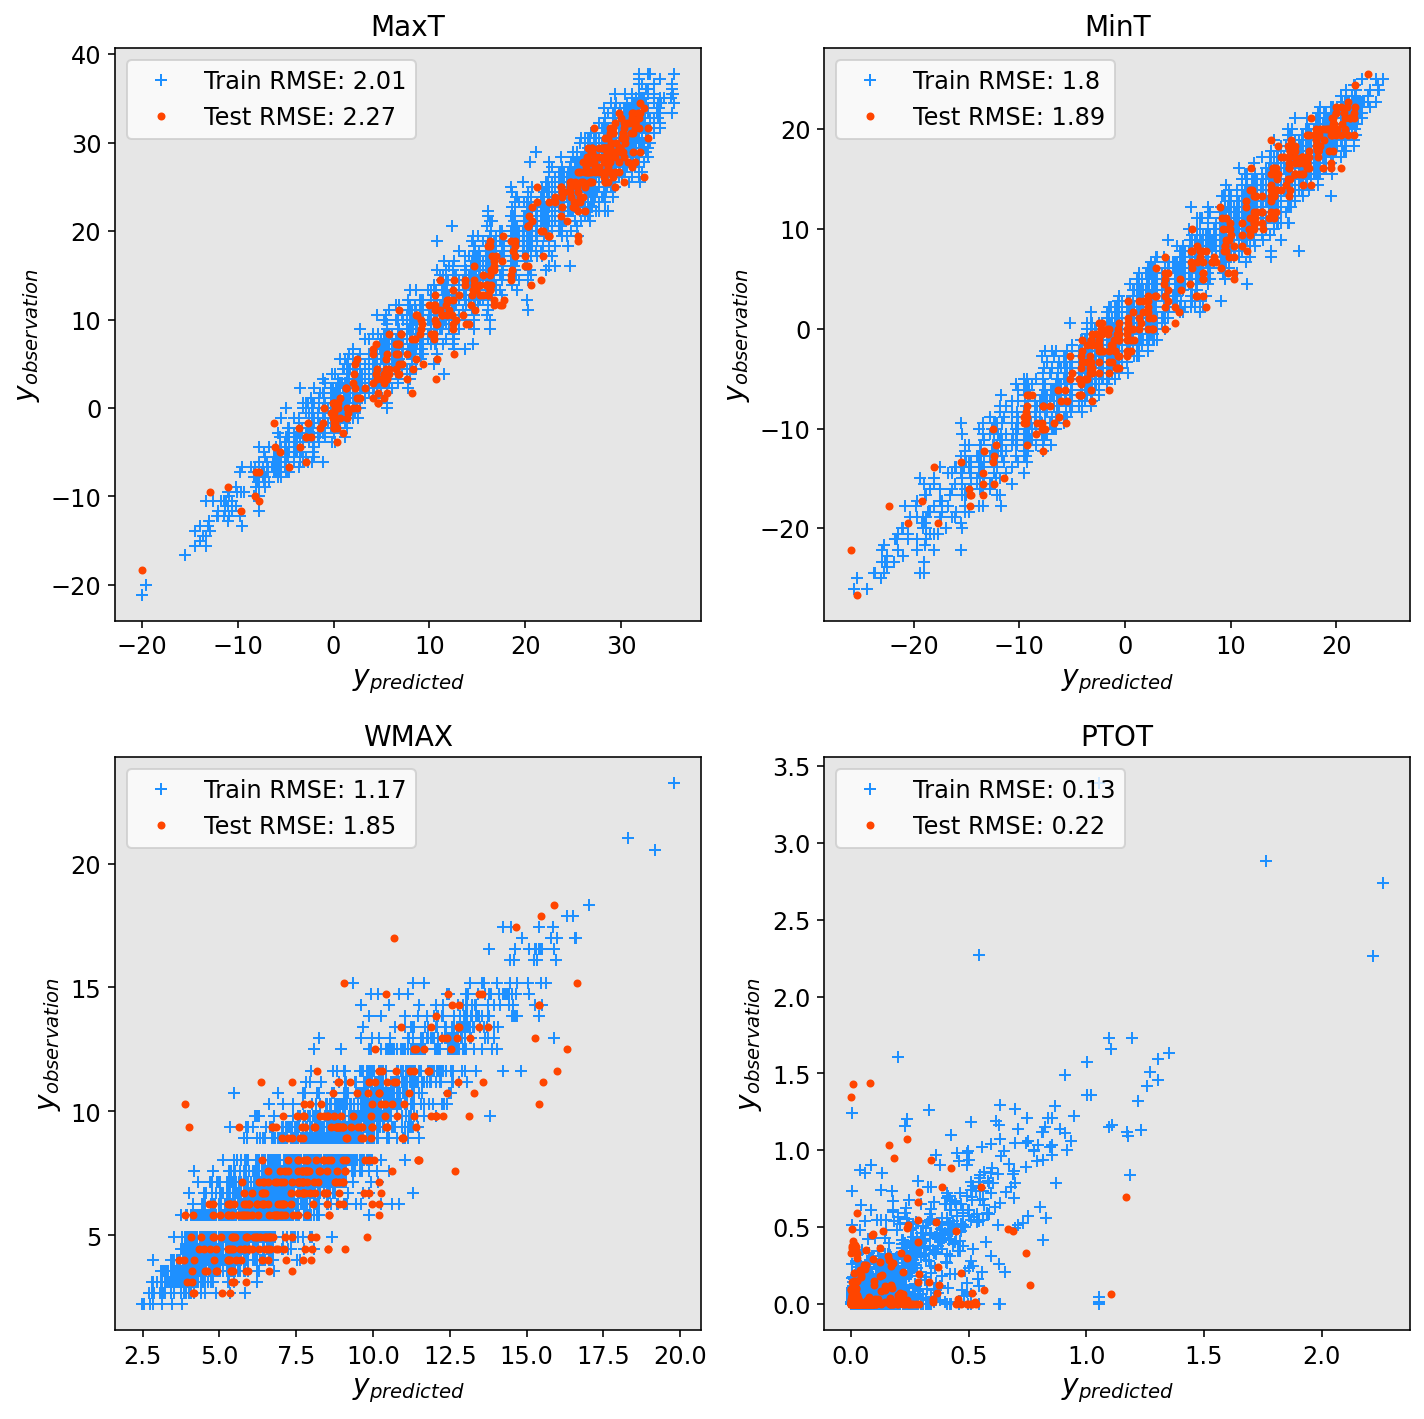

In [109]:
import copy 
fig,axes = plt.subplots(2,2,figsize=(10,10))

axes = np.ravel(axes)
for i,ii in enumerate(list(wx.regress_dict.keys())):
  ax = axes[i]
  reg_obj = copy.copy(wx.regress_dict[ii])
  ax.plot(reg_obj.yhat_train,reg_obj.y_train,'+',color='dodgerblue',label='Train RMSE: {}'.format(np.round(wx.regress_dict[ii].rmse_train,2)))
  ax.plot(reg_obj.yhat_test,reg_obj.y_test,'.',color='orangered',label='Test RMSE: {}'.format(np.round(wx.regress_dict[ii].rmse_test,2)))
  ax.set_xlabel('$y_{predicted}$')
  ax.set_ylabel('$y_{observation}$')
  ax.set_title(ii)
  ax.legend(loc=2)
  
fig.tight_layout()

# Development area 

In [0]:
filenames = glob.glob('./bufkit/*.gfs_kcmi.buf_prof.csv')
filenames.sort()

dfs = []
for i in filenames[0:1]:
  dfs.append(pd.read_csv(i))

In [0]:
import xarray as xr 
def strip_split_assign(ugly_format):
  ugly_format = ugly_format.strip('[]')
  ugly_format = ugly_format.split(',')
  good_format = np.asarray(ugly_format,dtype=float)
  return good_format

index = pd.to_datetime(dfs[0]['Unnamed: 0'])
# df = dfs[0].drop('Unnamed: 0')
# df = pd.DataFrame(data=df)

def make_ds(df,dtime):
  list_o_keys = list(df.keys())
  list_o_da = []
  for i in list_o_keys:
    if i == 'Unnamed: 0':
      continue
    da = xr.DataArray(build_mat(df[i]),dims={'time':dtime.values,
                                               'pressure': np.array([925,850,700,500,250,100])},coords={'time':dtime.values,
                                               'pressure': np.array([925,850,700,500,250,100])},name=i)
    list_o_da.append(da)

  ds = xr.merge(list_o_da)
  return ds

def build_mat(column_data):
  mat = np.zeros([len(column_data),6])
  for i in np.arange(0,len(column_data)):
    mat[i,:] = strip_split_assign(column_data[i])
  return mat

def concat_all_prof_files(filenames):
  list_of_ds = []
  for i in filenames:
    df = pd.read_csv(i)
    index = pd.to_datetime(df['Unnamed: 0'])
    ds = make_ds(df,index)

    list_of_ds.append(ds)
  
  ds = xr.concat(list_of_ds,dim='time')

  return ds 

ds = concat_all_prof_files(filenames)
# ds
# filenames[0]

# make_

In [0]:
# ds_oneday = ds.where(ds.time >= np.datetime64('2010-01-02T06:00:00'))
# ds_oneday = ds_oneday.where(ds_oneday.time <= np.datetime64('2010-01-03T06:00:00'))
# ds_oneday = ds_oneday.dropna(dim='time',how='all')
# ds_oneday.time
# ds.shape
#there are 9 profiles for each forecast time 
ind = np.arange(0,len(ds.time),9)
ds.time.values[ind[0]:ind[1]]
# ind

array(['2010-01-02T06:00:00.000000000', '2010-01-02T09:00:00.000000000',
       '2010-01-02T12:00:00.000000000', '2010-01-02T15:00:00.000000000',
       '2010-01-02T18:00:00.000000000', '2010-01-02T21:00:00.000000000',
       '2010-01-03T00:00:00.000000000', '2010-01-03T03:00:00.000000000',
       '2010-01-03T06:00:00.000000000'], dtype='datetime64[ns]')

we see that for Jan 1 2010, the forecast for 2010-01-02 was:

High = -11.26 degC

Low = -16.46 degC

WMAX = 7.32 m/s

Precip = 0.05 inches

Let's make the dataframe for the forecasts

In [0]:
# Python code to demonstrate converting  
# string representation of list to list 
# using json.loads() 
import json 
  
# initializing string representation of a list 
ini_list = "[1, 2, 3, 4, 5]"
  
# printing intialized string of list and its type 
print ("initial string", ini_list) 
print (type(ini_list)) 
  
# Converting string to list 
res = json.loads(ini_list) 
  
# printing final result and its type 
print ("final list", res) 
print (type(res)) 

initial string [1, 2, 3, 4, 5]
<class 'str'>
final list [1, 2, 3, 4, 5]
<class 'list'>


In [0]:
#load the truth data
truth_df = pd.read_csv('./ATMS-597-SP-2020-Project4-GroupG/ATMS-597-SP-2020-Project-4/KCMI_daily.csv',skiprows=8)
truth_df = truth_df.drop(columns='Unnamed: 5')
truth_df = truth_df.dropna(how='any')
truth_df.head()

,Date,Max Hourly Temp (F),Min Hourly Temp (F),Max Wind Speed (mph),Total Precip (in)
0,2010-01-01,12,2,15,M
1,2010-01-02,6,-5,15,0.00
2,2010-01-03,10,-6,11,0.00
3,2010-01-04,11,-2,20,0.00
4,2010-01-05,10,-1,16,M


For now, lets just look at temperature 

In [0]:
truth_df = truth_df.drop(columns='Total Precip (in)')

In [0]:
series_df = pd.DataFrame(data={'MaxT':truth_df['Max Hourly Temp (F)'].values,'MinT':truth_df['Min Hourly Temp (F)'].values,},index=pd.to_datetime(truth_df['Date'].values))

#split into train and test 
df_obs_train = series_df.iloc[series_df.index.values < np.datetime64('2019-01-01')]
df_obs_test = series_df.iloc[series_df.index.values >= np.datetime64('2019-01-01')]

In [0]:
#fill missing values with np.nan
df_obs_train = df_obs_train.where((df_obs_train.MaxT != 'M'))
df_obs_train = df_obs_train.where((df_obs_train.MinT != 'M'))
#convert to floats and deg C 
df_obs_train.MaxT = (df_obs_train.MaxT.astype(float) - 32)*(5/9.)
df_obs_train.MinT = (df_obs_train.MinT.astype(float) - 32)*(5/9.)

#fill missing values with np.nan
df_obs_test = df_obs_test.where((df_obs_test.MaxT != 'M'))
df_obs_test = df_obs_test.where((df_obs_test.MinT != 'M'))
#convert to floats and deg C 
df_obs_test.MaxT = (df_obs_test.MaxT.astype(float) - 32)*(5/9.)
df_obs_test.MinT = (df_obs_test.MinT.astype(float) - 32)*(5/9.)

df_obs_train.head()

,MaxT,MinT
2010-01-01,-11.111111,-16.666667
2010-01-02,-14.444444,-20.555556
2010-01-03,-12.222222,-21.111111
2010-01-04,-11.666667,-18.888889
2010-01-05,-12.222222,-18.333333


In [0]:
#valid training range
dtime_index_train = pd.date_range(start='2010-01-02',end='2018-12-31')
#valid testing range 
dtime_index_test = pd.date_range(start='2019-01-01',end='2019-12-31')

df_forecast_train = df_forecast_train.reindex(index=dtime_index_train)
df_obs_train = df_obs_train.reindex(index=dtime_index_train)

df_forecast_test = df_forecast_test.reindex(index=dtime_index_test)
df_obs_test = df_obs_test.reindex(index=dtime_index_test)

Ok. now we can do SKLEARN things

In [0]:
import sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

X_train = df_forecast_train.MaxT.values
y_train = df_obs_train.MaxT.values

X_test = df_forecast_test.MaxT.values
y_test = df_obs_test.MaxT.values

ind = np.isnan(X_train)
X_train = X_train[~ind]
y_train = y_train[~ind]

ind = np.isnan(y_train)
X_train = X_train[~ind]
y_train = y_train[~ind]

ind = np.isnan(X_test)
X_test = X_test[~ind]
y_test = y_test[~ind]

ind = np.isnan(y_test)
X_test = X_test[~ind]
y_test = y_test[~ind]

X_train = X_train.reshape(X_train.shape[0],1)
X_test = X_test.reshape(X_test.shape[0],1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


reg = LinearRegression().fit(X_train_scaled, y_train)
y_hat = reg.predict(X_test_scaled)

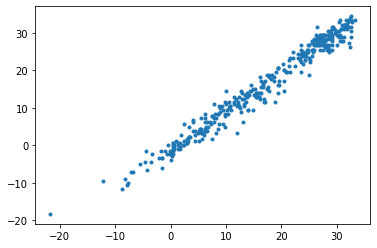

In [0]:
plt.plot(y_hat,y_test,'.')

In [0]:
reg.score(X_test_scaled,y_test)

0.9675801863384572

In [0]:
np.mean(np.abs(y_hat - y_test))

1.6368555736721184

In [0]:
class wxchallenge():

  def __init__(self):
    self.intialized = True
  
  def preprocess_daily(self):

    """
    Method to preprocess the daily forecast files (most simple model)
    """

    filenames = glob.glob('./bufkit/*.gfs_kcmi.buf_daily.csv')
    filenames.sort()

    dfs = []
    for i in filenames:
      dfs.append(pd.read_csv(i))

    df_temp = pd.concat(dfs)
    df_forecast = pd.DataFrame(data={'MaxT':df_temp['TMAX'].values,'MinT':df_temp['TMIN'].values,'WMAX':df_temp['WMAX'].values,'PTOT':df_temp['PTOT'].values,},index=pd.to_datetime(pd.to_datetime(df_temp['Unnamed: 0'].values).date)+datetime.timedelta(days=1))

    #split the data into train and test 
    df_forecast_train = df_forecast.iloc[df_forecast.index.values < np.datetime64('2019-01-01')]
    df_forecast_test = df_forecast.iloc[df_forecast.index.values >= np.datetime64('2019-01-01')]

    #valid training range
    dtime_index_train = pd.date_range(start='2010-01-02',end='2018-12-31')
    df_forecast_train = df_forecast_train.reindex(index=dtime_index_train)

    #valid testing range 
    dtime_index_test = pd.date_range(start='2019-01-01',end='2019-12-31')
    df_forecast_test = df_forecast_test.reindex(index=dtime_index_test)

    self.daily_train = df_forecast_train
    self.daily_test = df_forecast_test

  def preprocess_truth(self):

    #load the truth data
    truth_df = pd.read_csv('./ATMS-597-SP-2020-Project4-GroupG/ATMS-597-SP-2020-Project-4/KCMI_daily.csv',skiprows=8)
    truth_df = truth_df.drop(columns='Unnamed: 5')
    truth_df = truth_df.dropna(how='any')
    truth_df.head()


    truth_df = truth_df.drop(columns='Total Precip (in)')

    series_df = pd.DataFrame(data={'MaxT':truth_df['Max Hourly Temp (F)'].values,'MinT':truth_df['Min Hourly Temp (F)'].values,'WMAX':truth_df['Max Wind Speed (mph)'].values},index=pd.to_datetime(truth_df['Date'].values))

    #split into train and test 
    df_obs_train = series_df.iloc[series_df.index.values < np.datetime64('2019-01-01')]
    df_obs_test = series_df.iloc[series_df.index.values >= np.datetime64('2019-01-01')]

    #fill missing values with np.nan
    df_obs_train = df_obs_train.where((df_obs_train.MaxT != 'M'))
    df_obs_train = df_obs_train.where((df_obs_train.MinT != 'M'))
    df_obs_train = df_obs_train.where((df_obs_train.WMAX != 'M'))
    #convert to floats and deg C 
    df_obs_train.MaxT = (df_obs_train.MaxT.astype(float) - 32)*(5/9.)
    df_obs_train.MinT = (df_obs_train.MinT.astype(float) - 32)*(5/9.)
    #convert to floats and m/s
    df_obs_train.WMAX  = (df_obs_train.WMAX.astype(float)) * 0.44704

    #fill missing values with np.nan
    df_obs_test = df_obs_test.where((df_obs_test.MaxT != 'M'))
    df_obs_test = df_obs_test.where((df_obs_test.MinT != 'M'))
    df_obs_test = df_obs_test.where((df_obs_test.WMAX != 'M'))
    #convert to floats and deg C 
    df_obs_test.MaxT = (df_obs_test.MaxT.astype(float) - 32)*(5/9.)
    df_obs_test.MinT = (df_obs_test.MinT.astype(float) - 32)*(5/9.)
    #convert to floats and m/s
    df_obs_test.WMAX  = (df_obs_test.WMAX.astype(float)) * 0.44704

    #valid training range
    dtime_index_train = pd.date_range(start='2010-01-02',end='2018-12-31')
    df_obs_train = df_obs_train.reindex(index=dtime_index_train)
    #valid testing range 
    dtime_index_test = pd.date_range(start='2019-01-01',end='2019-12-31')
    df_obs_test = df_obs_test.reindex(index=dtime_index_test)

    self.obs_train = df_obs_train
    self.obs_test = df_obs_test

In [0]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
df_forecast_train = df_forecast.iloc[df_forecast.index.values < np.datetime64('2019-01-01')]
df_forecast_test = df_forecast.iloc[df_forecast.index.values >= np.datetime64('2019-01-01')]

In [0]:
wx = wxchallenge()
wx.preprocess_daily()
wx.preprocess_truth()
# wx.prep

In [0]:
hourly = './ATMS-597-SP-2020-Project4-GroupG/ATMS-597-SP-2020-Project-4/KCMI_hourly.csv'
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
df = pd.read_csv(hourly)

In [0]:
wx.obs_train

,MaxT,MinT,WMAX
2010-01-02,-14.444444,-20.555556,6.70560
2010-01-03,-12.222222,-21.111111,4.91744
2010-01-04,-11.666667,-18.888889,8.94080
2010-01-05,-12.222222,-18.333333,7.15264
2010-01-06,-7.777778,-19.444444,3.57632
...,...,...,...
2018-12-27,12.222222,3.888889,14.75232
2018-12-28,10.555556,-2.222222,10.28192
2018-12-29,-2.222222,-5.000000,7.15264
2018-12-30,2.222222,-7.777778,9.38784


In [0]:
pd.read_csv('./ATMS-597-SP-2020-Project4-GroupG/KCMI_daily_updated.csv')

,Unnamed: 0,Date,Max Hourly Temp (F),Min Hourly Temp (F),Max Wind Speed (mph),Total Precip (in),Day of Year
0,0,2010-01-01,12,2,15,0.0,1
1,1,2010-01-02,6,-5,15,0.0,2
2,2,2010-01-03,10,-6,11,0.0,3
3,3,2010-01-04,11,-2,20,0.0,4
4,4,2010-01-05,10,-1,16,0.0,5
...,...,...,...,...,...,...,...
3647,3647,2019-12-27,43,32,15,0.0,361
3648,3648,2019-12-28,56,32,23,2.8,362
3649,3649,2019-12-29,59,41,23,4.3,363
3650,3650,2019-12-30,38,31,26,0.6,364


In [0]:
truth_df = pd.read_csv('./ATMS-597-SP-2020-Project4-GroupG/KCMI_daily_updated.csv')

    # truth_df = truth_df.drop(columns='Total Precip (in)')

series_df = pd.DataFrame(data={'MaxT':truth_df['Max Hourly Temp (F)'].values,'MinT':truth_df['Min Hourly Temp (F)'].values,'WMAX':truth_df['Max Wind Speed (mph)'].values,'PTOT':truth_df['Total Precip (in)'].values},index=pd.to_datetime(truth_df['Date'].values))

In [0]:
truth_df,series_df

(      Unnamed: 0        Date  ... Total Precip (in) Day of Year
 0              0  2010-01-01  ...               0.0           1
 1              1  2010-01-02  ...               0.0           2
 2              2  2010-01-03  ...               0.0           3
 3              3  2010-01-04  ...               0.0           4
 4              4  2010-01-05  ...               0.0           5
 ...          ...         ...  ...               ...         ...
 3647        3647  2019-12-27  ...               0.0         361
 3648        3648  2019-12-28  ...               2.8         362
 3649        3649  2019-12-29  ...               4.3         363
 3650        3650  2019-12-30  ...               0.6         364
 3651        3651  2019-12-31  ...               0.0         365
 
 [3652 rows x 7 columns],            MaxT MinT WMAX  PTOT
 2010-01-01   12    2   15   0.0
 2010-01-02    6   -5   15   0.0
 2010-01-03   10   -6   11   0.0
 2010-01-04   11   -2   20   0.0
 2010-01-05   10   -1   16  